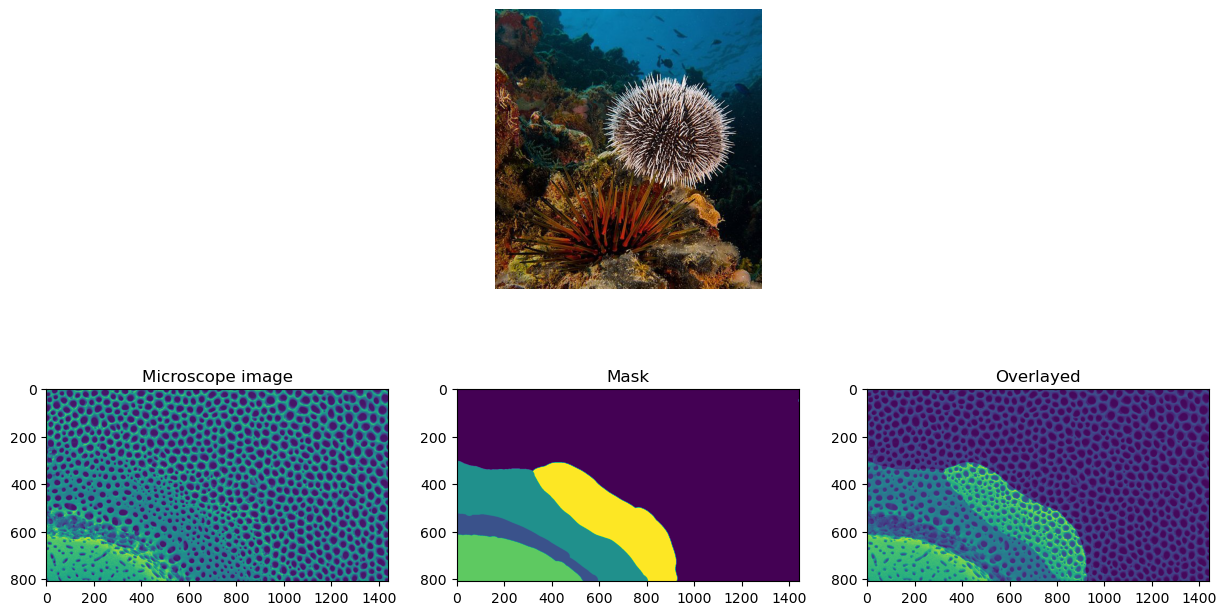

In [216]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color           import label2rgb
from skimage.feature import graycomatrix, graycoprops
from tqdm.notebook import tqdm

photo = io.imread('figures/Tripneustes_ventricosus.jpg')
img   = io.imread('data/sea-urchin-skeleton.jpg').mean(axis=2).astype(int)
mask  = io.imread('data/sea-urchin-skeleton_feat.png')

fig, ax = plt.subplots(2,3,figsize=(15,8))
ax=ax.ravel()
ax[0].axis('off')
ax[1].imshow(photo)
ax[1].axis('off')
ax[2].axis('off')
ax[3].imshow(img)
ax[3].set_title('Microscope image')
ax[4].imshow(mask)
ax[4].set_title('Mask');
ax[5].imshow((20*mask+50)*img)
ax[5].set_title('Overlayed');

[Microscope image source](https://www.sciencenews.org/article/sea-urchin-skeletons-patterns-structure)

In [68]:
# Factor 1440
x=np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 16, 18, 20, 24, 30, 32, 36, 40, 45, 48, 60, 72, 80, 90, 96, 120, 144, 160, 180, 240, 288, 360, 480, 720, 1440])
# Factor
y=np.array([1, 2, 3, 5, 6, 9, 10, 15, 18, 27, 30, 45, 54, 81, 90, 135, 162, 270, 405, 810])

np.intersect1d(x,y)

array([ 1,  2,  3,  5,  6,  9, 10, 15, 18, 30, 45, 90])

In [208]:
xx, yy = np.meshgrid(
    np.arange(img.shape[1]),
    np.arange(img.shape[0]))
N=45 # one of [ 1,  2,  3,  5,  6,  9, 10, 15, 18, 30, 45, 90]
M=810/N
region_labels = (xx//N) * M+yy//N
region_labels = region_labels.astype(int)

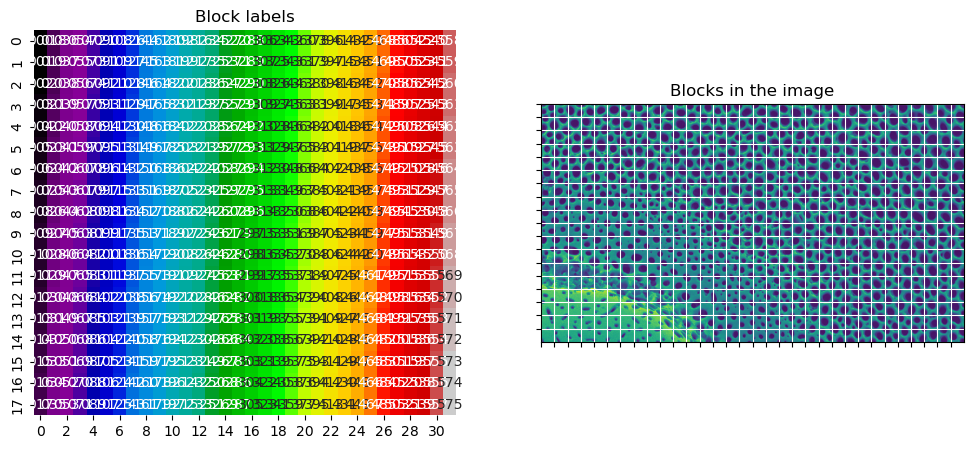

In [209]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.heatmap(region_labels[::N, ::N].astype(int),
            annot=True,
            fmt="03d",
            cmap='nipy_spectral',
            cbar=False,
            ax=ax[0]
            );
ax[0].set_title('Block labels')

ax[1].imshow(img)
ax[1].set_xticks(np.arange(0,img.shape[1],N))
ax[1].set_yticks(np.arange(0,img.shape[0],N))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].grid(visible=True, which='major', axis='both',color='white')
ax[1].set_title('Blocks in the image');

In [210]:
grayco_prop_list = ['contrast', 'dissimilarity',
                    'homogeneity', #'energy',
                    'correlation', 'ASM']

prop_imgs = {}
for c_prop in grayco_prop_list:
    prop_imgs[c_prop] = np.zeros_like(img, dtype=np.float32)
score_img = np.zeros_like(img, dtype=np.float32)
out_df_list = []
for patch_idx in np.unique(region_labels):
    xx_box, yy_box = np.where(region_labels == patch_idx)

    glcm = graycomatrix(img[xx_box.min():xx_box.max(),yy_box.min():yy_box.max()],
                        [4,8,16], np.linspace(0,np.pi,6), 256, symmetric=False, normed=True)

    mean_score = np.round(np.mean(mask[region_labels == patch_idx]))
    score_img[region_labels == patch_idx] = mean_score

    out_row = dict(
        intensity_mean = img[region_labels == patch_idx].mean(),
        intensity_std  = img[region_labels == patch_idx].std(),
        score          = mean_score)

    for c_prop in grayco_prop_list:
        out_row[c_prop] = graycoprops(glcm, c_prop)[0, 0]
        prop_imgs[c_prop][region_labels == patch_idx] = out_row[c_prop]

    out_df_list += [out_row];

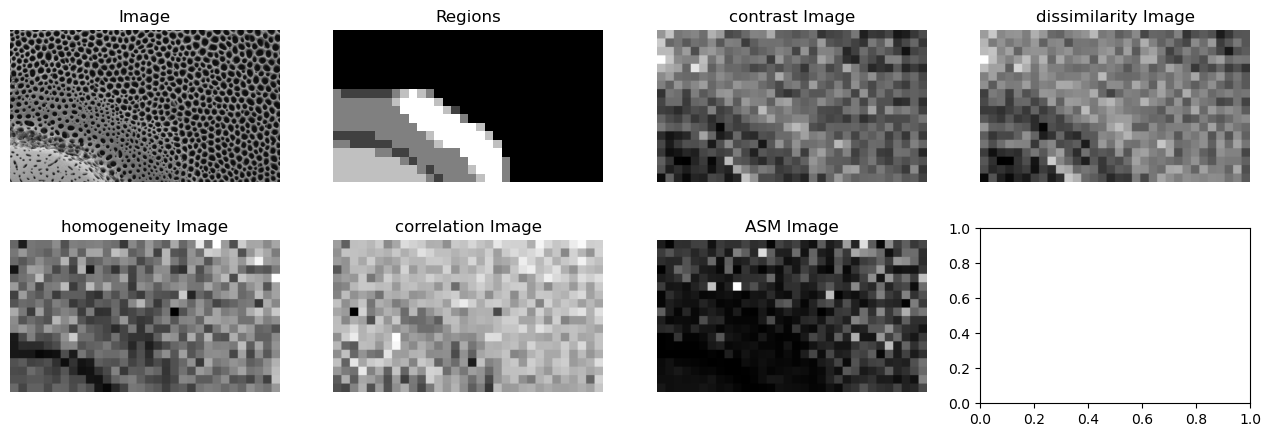

In [211]:
# show the slice and threshold
fig, m_axs = plt.subplots(2, 4, figsize=(16, 5))
n_axs = m_axs.flatten()
ax1 = n_axs[0]
ax2 = n_axs[1]
ax1.imshow(img, cmap='gray')
ax1.axis('off')
ax1.set_title('Image')
ax2.imshow(score_img, cmap='gray',interpolation='none')
ax2.axis('off')
ax2.set_title('Regions')
for c_ax, c_prop in zip(n_axs[2:], grayco_prop_list):
    c_ax.imshow(prop_imgs[c_prop], cmap='gray')
    c_ax.axis('off')
    c_ax.set_title('{} Image'.format(c_prop))

In [212]:
import pandas as pd
out_df = pd.DataFrame(out_df_list)
# out_df['positive_score'] = out_df['score'].map(
#     lambda x: 'FG' if x > 0 else 'BG')
out_df.describe()

,intensity_mean,intensity_std,score,contrast,dissimilarity,homogeneity,correlation,ASM
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,124.780106,38.746727,0.892361,838.267317,19.241571,0.134779,0.717064,0.003602
std,15.199643,4.817250,1.368799,210.390319,3.074309,0.036716,0.073649,0.002774
min,103.692840,18.850010,0.000000,294.831250,9.936364,0.039429,0.361133,0.000664
25%,116.003457,37.066160,0.000000,701.817898,17.278977,0.110028,0.675319,0.001587
50%,121.147160,39.876545,0.000000,839.182670,19.560511,0.134236,0.729786,0.002786
75%,127.854691,41.880364,2.000000,963.301136,21.247301,0.158841,0.765444,0.004742
max,191.684444,50.192793,4.000000,1729.901136,30.837500,0.262716,0.891337,0.018431


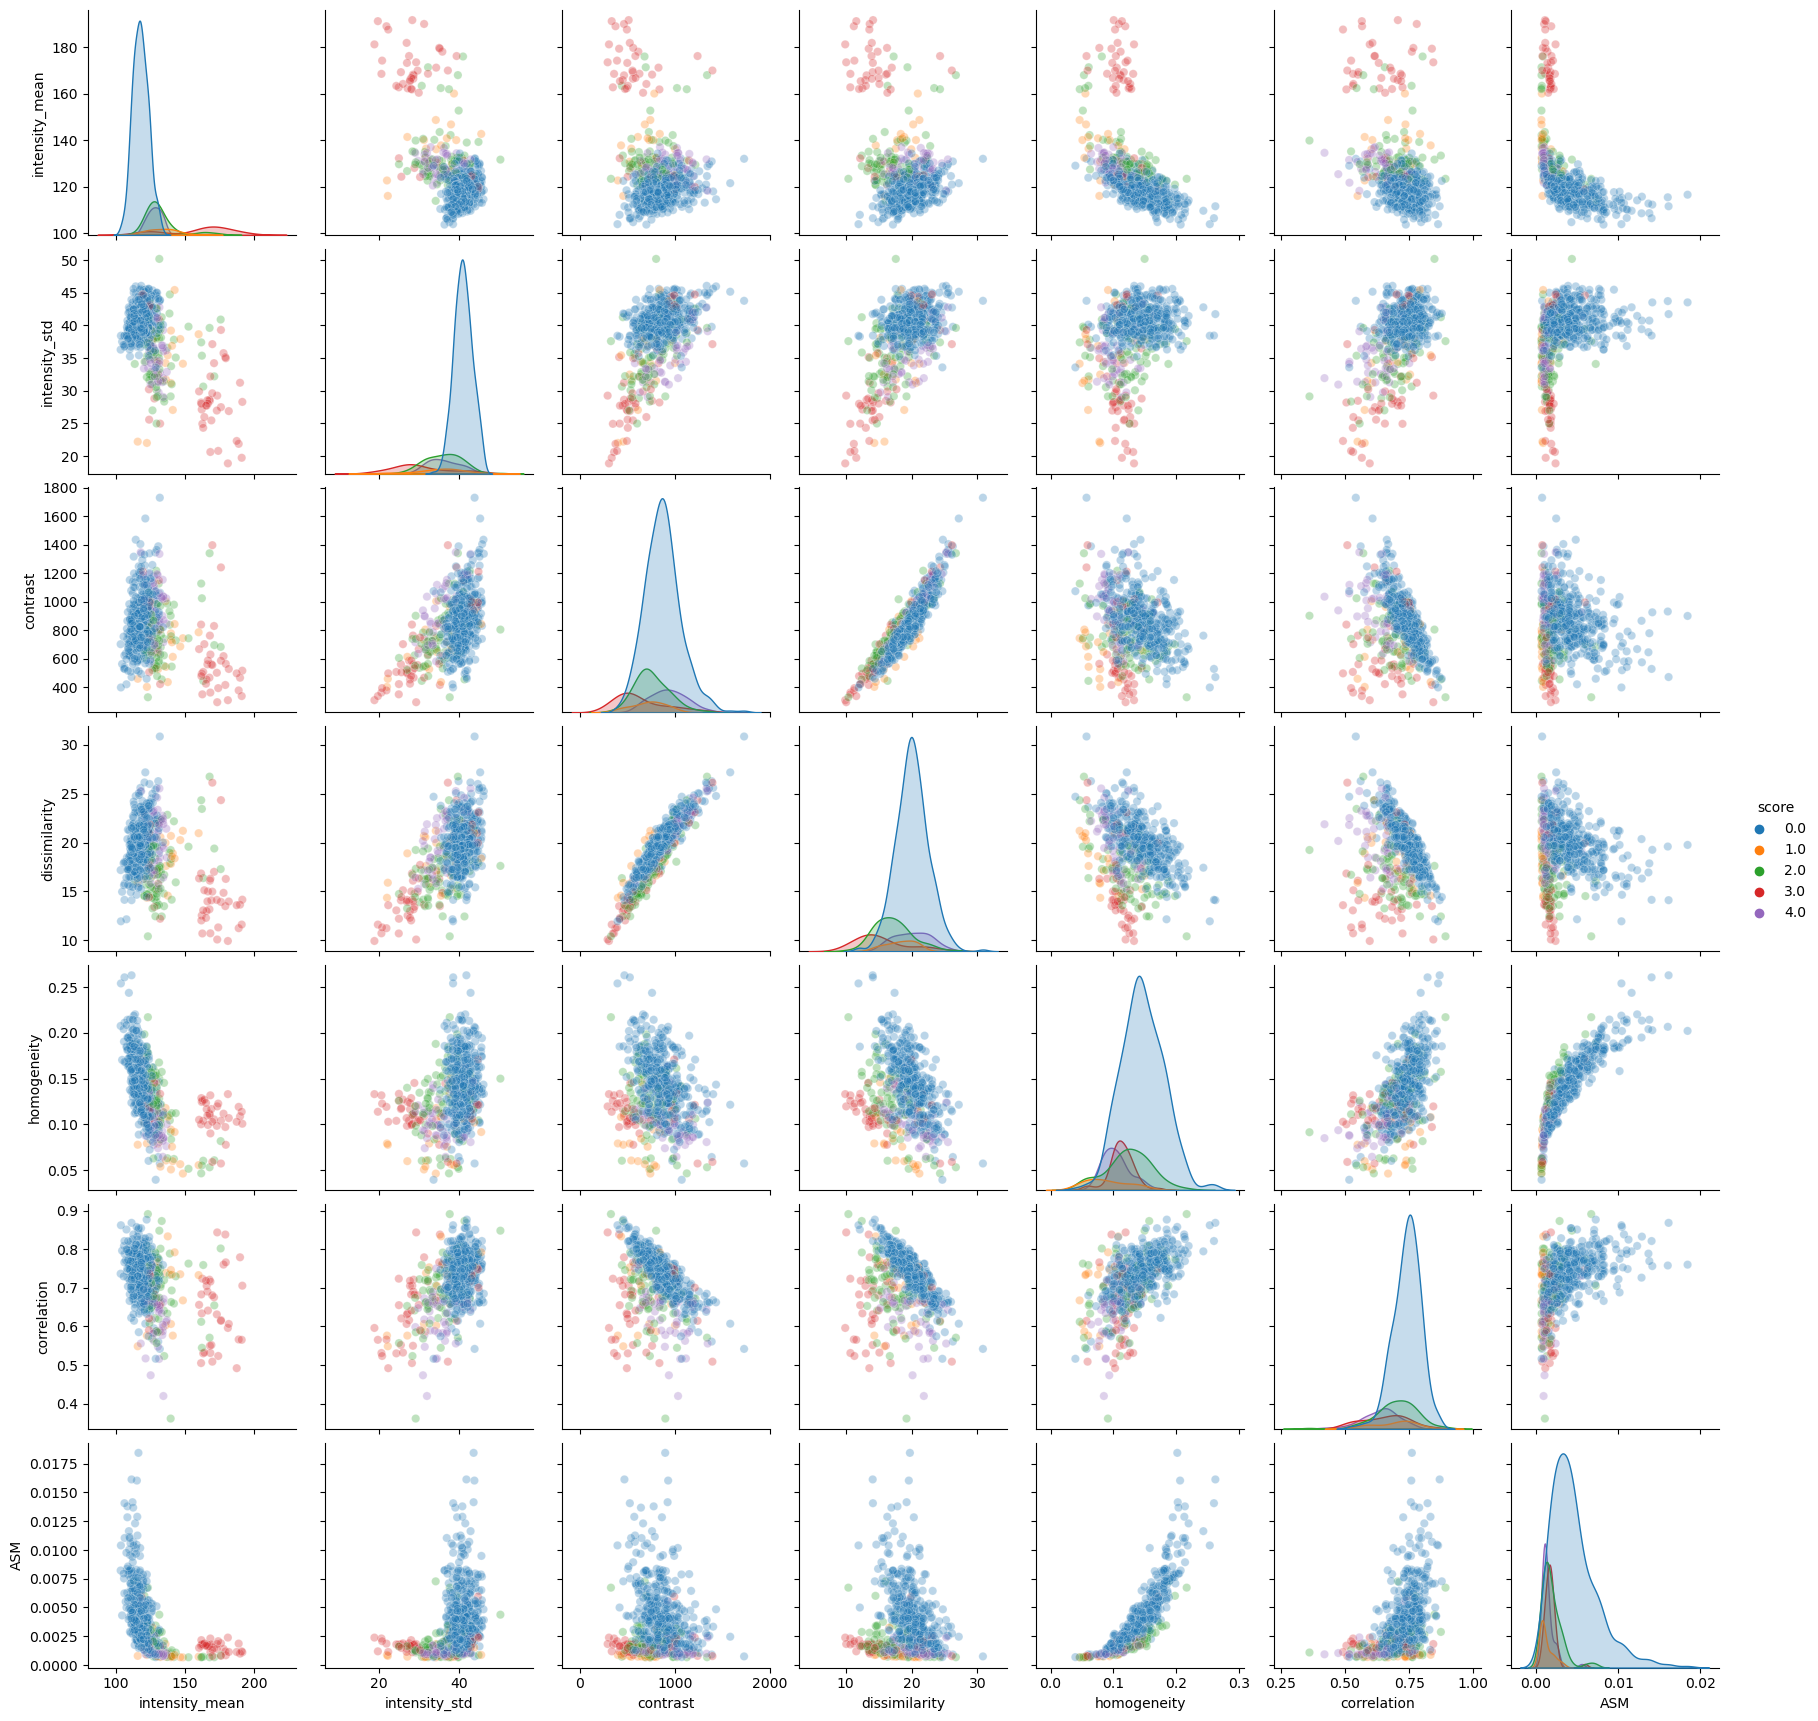

In [214]:
sns.pairplot(out_df,hue='score',plot_kws={'alpha': 0.3}, palette=sns.color_palette("tab10")[0:5]);

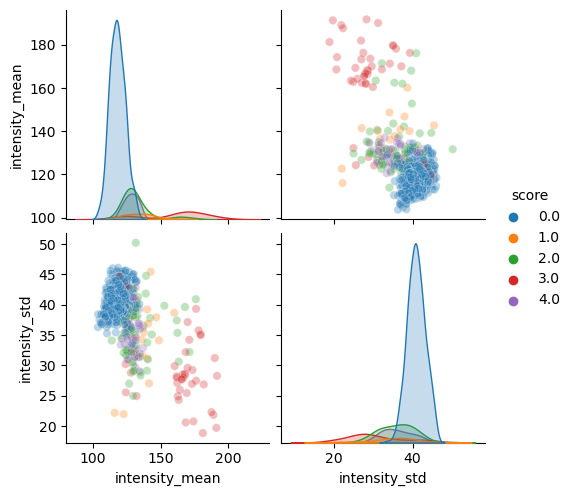

In [220]:
sns.pairplot(out_df,vars=['intensity_mean','intensity_std'],hue='score',plot_kws={'alpha': 0.3}, palette=sns.color_palette("tab10")[0:5]);

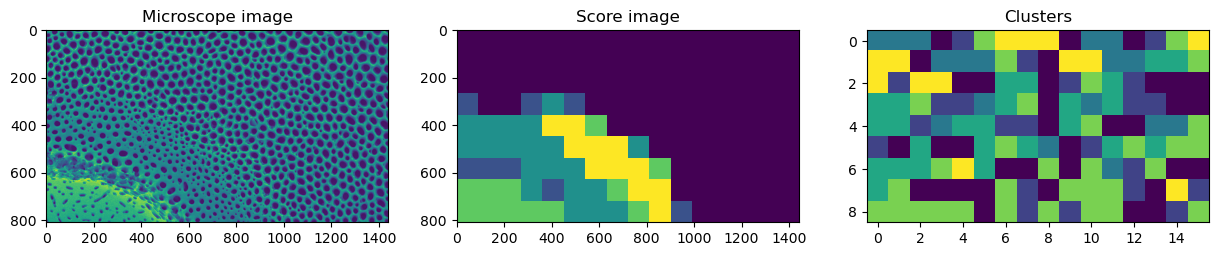

In [207]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=6, random_state=2018,n_init='auto')
featurelist = [
                'intensity_mean',
                'intensity_std',
#                 'score',
                'contrast',
       #         'dissimilarity',
                'homogeneity',
      #          'energy',
                'correlation',
                'ASM']
out_df['group'] = km.fit_predict(out_df[featurelist].values)
seg         = out_df['group'].values.reshape(region_labels[::N, ::N].shape)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(img)
ax[0].set_title('Microscope image')
ax[1].imshow(score_img,interpolation='none')
ax[1].set_title('Score image');
ax[2].imshow(seg)
ax[2].set_title('Clusters');